In [10]:
import tensorflow as tf
import numpy as np
from keras.datasets import mnist

In [11]:
"""Load data"""

(X_train, y_train), (X_test, y_test) = mnist.load_data(path="mnist.npz")
num_classes = 10 # 0 through 9

# One-hot encode y_train and y_test
y_train = np.array([np.array([0]*(y)+[1]+[0]*(num_classes-y-1)) for y in y_train])
y_test  = np.array([np.array([0]*(y)+[1]+[0]*(num_classes-y-1)) for y in y_test])

# Flatten Xs
X_train = np.array([X.flatten() for X in X_train])
X_test  = np.array([X.flatten() for X in X_test])

# Create placeholders
input_size = X_train.shape[1]
X = tf.placeholder("float", [None, input_size])
y = tf.placeholder("float", [None, num_classes])

In [23]:
"""Hyperparams"""

BATCH_SIZE = 100
EPOCHS = 15
LEARNING_RATE = 0.01
DROPOUT = 0.75 # Only used for ConvNets
ACC_EVERY = 1 # Print accuracy every __

In [24]:
"""Utility functions"""

activation = tf.nn.relu

def init_weights(weights_sizes):
    return [tf.Variable(tf.random_normal(weight_size))
           for weight_size in weights_sizes]

def init_biases(biases_sizes):
    return [tf.Variable(tf.random_normal([bias_size])) for bias_size in biases_sizes]

def fully_connected(prev_layer, weight, bias, activation=activation):
    layer = tf.add(tf.matmul(prev_layer, weight), bias)
    layer = activation(layer)
    return layer

def convolution(X, W, b, stride=1):
    X = tf.nn.conv2d(X, W, strides=[1, stride, stride, 1], padding='SAME')
    X = tf.nn.bias_add(X, b)
    return activation(X)

def max_pool(X):
    return tf.nn.max_pool(X, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def autoencode_X(sess, decoder, x, autoencode=False):
    if autoencode:
        return sess.run(decoder, feed_dict={X: x})
    else:
        return x

('Epoch:', '0001', 'cost=', 'nan')
('Accuracy ', 7419.2246)


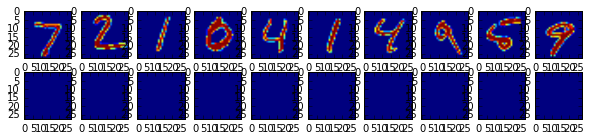

KeyboardInterrupt: 

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

VIS_DECODE = True
encode_sizes = [input_size, 256, 128]
decode_sizes = encode_sizes[::-1]

encode_weights = [tf.Variable(tf.random_normal([inp, out])) for inp, out in zip(encode_sizes[:-1], encode_sizes[1:])]
decode_weights = [tf.Variable(tf.random_normal([inp, out])) for inp, out in zip(decode_sizes[:-1], decode_sizes[1:])]

encode_biases = [tf.Variable(tf.random_normal([out])) for out in encode_sizes[1:]]
decode_biases = [tf.Variable(tf.random_normal([out])) for out in decode_sizes[1:]]

n_input, n_hidden_1, n_hidden_2 = input_size, 256, 128

# encode_weights = [
#     tf.Variable(tf.random_normal([n_input, n_hidden_1])),
#     tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
# ]

# decode_weights =[
#     tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
#     tf.Variable(tf.random_normal([n_hidden_1, n_input])),
# ]

# encode_biases = [
#     tf.Variable(tf.random_normal([n_hidden_1])),
#     tf.Variable(tf.random_normal([n_hidden_2])),
# ]
# decode_biases =[
#     tf.Variable(tf.random_normal([n_hidden_1])),
#     tf.Variable(tf.random_normal([n_input])),
# ]

def encoder(x):
    layers = [x]
    for weight, bias in zip(encode_weights, encode_biases):
        layers.append(activation(tf.add(tf.matmul(
            layers[-1], weight), bias)))
    return layers[-1]


def decoder(x):
    layers = [x]
    for weight, bias in zip(decode_weights, decode_biases):
        layers.append(activation(tf.add(tf.matmul(
            layers[-1], weight), bias)))
    return layers[-1]


encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

y_pred = decoder_op
y_true = X

cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(LEARNING_RATE).minimize(cost)

init = tf.global_variables_initializer()

BATCH_SIZE = 5

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(EPOCHS):
        for step in range(len(X_train)//BATCH_SIZE):
            start_ind = (step*BATCH_SIZE) % len(X_train)
            end_ind = ((step+1)*BATCH_SIZE) % len(X_train)
            batch_xs = X_train[start_ind:end_ind]
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
        if epoch % ACC_EVERY == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))
        
        decoded_X_test = sess.run(y_pred, feed_dict={X: X_test})
        print("Accuracy ", tf.reduce_mean(tf.pow(X_test - decoded_X_test, 2)).eval())
        f, a = plt.subplots(2, 10, figsize=(10, 2))
        for i in range(len(X_test[:10])):
            a[0][i].imshow(np.reshape(X_test[i], (28, 28)))
            a[1][i].imshow(np.reshape(decoded_X_test[i], (28, 28)))
        f.show()
        plt.draw()
        plt.show()

print("Optimization Finished!")

In [53]:
"""Multilayer perceptron"""
# Hooray, generalized!
# https://www.tensorflow.org used as reference
# https://github.com/aymericdamien/TensorFlow-Examples was also useful

layers_sizes = [255, 255]

weights_sizes = zip([input_size]+layers_sizes, layers_sizes+[num_classes])
biases_sizes = layers_sizes+[num_classes]
weights = init_weights(weights_sizes)
biases = init_biases(biases_sizes)


def mlp_layers():
    layers = []
    for ind, layer_size in enumerate(layers_sizes):
        try:
            last_layer = layers[-1]
        except IndexError:
            last_layer = X
        layers.append(fully_connected(last_layer, weights[ind], biases[ind]))
    layers.append(tf.add(tf.matmul(layers[-1], weights[-1]), biases[-1]))
    return layers

predictor = mlp_layers()[-1]
x_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictor, labels=y))
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(x_entropy)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

for epoch in range(EPOCHS):
    for step in range(len(X_train)//BATCH_SIZE):
        start_ind = (step*BATCH_SIZE) % len(X_train)
        end_ind = ((step+1)*BATCH_SIZE) % len(X_train)
        batch_X, batch_y = X_train[start_ind:end_ind], y_train[start_ind:end_ind]
        sess.run(train_step, feed_dict={X:batch_X, y:batch_y})
    
    if epoch%ACC_EVERY == 0:
        correct_prediction = tf.equal(tf.argmax(predictor, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print "Epoch ", str(epoch).zfill(3), " | Testing Acc:", accuracy.eval({X: X_test, y: y_test})

print "Final Accuracy:", accuracy.eval({X: X_test, y: y_test})

Epoch  000  | Testing Acc: 0.1153
Epoch  001  | Testing Acc: 0.1028
Epoch  002  | Testing Acc: 0.1028


KeyboardInterrupt: 

In [29]:
"""Multilayer perceptron WITH AUTOENCODER FUNCTIONALITY"""

USE_AUTOENCODING = True

layers_sizes = [255, 255]
weights_sizes = zip([input_size]+layers_sizes, layers_sizes+[num_classes])
biases_sizes = layers_sizes+[num_classes]
weights = init_weights(weights_sizes)
biases = init_biases(biases_sizes)

def mlp_layers():
    layers = []
    for ind, layer_size in enumerate(layers_sizes):
        try:
            last_layer = layers[-1]
        except IndexError:
            last_layer = X
        layers.append(fully_connected(last_layer, weights[ind], biases[ind]))
    layers.append(tf.add(tf.matmul(layers[-1], weights[-1]), biases[-1]))
    return layers

predictor = mlp_layers()[-1]
x_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictor, labels=y))
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(x_entropy)

sess = tf.InteractiveSession()
process_X = lambda x: autoencode_X(sess, decoder_op, x, autoencode=USE_AUTOENCODING)
tf.global_variables_initializer().run()

for epoch in range(EPOCHS):
    for step in range(len(X_train)//BATCH_SIZE):
        start_ind = (step*BATCH_SIZE) % len(X_train)
        end_ind = ((step+1)*BATCH_SIZE) % len(X_train)
        batch_X, batch_y = X_train[start_ind:end_ind], y_train[start_ind:end_ind]
        sess.run(train_step, feed_dict={X:process_X(batch_X), y:batch_y})
    
    if epoch%ACC_EVERY == 0:
        correct_prediction = tf.equal(tf.argmax(predictor, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print "Epoch ", str(epoch).zfill(3), " | Testing Acc:", accuracy.eval({X: process_X(X_test), y: y_test})

print "Final Accuracy:", accuracy.eval({X: process_X(X_test), y: y_test})

Epoch  000  | Testing Acc: 0.4648
Epoch  001  | Testing Acc: 0.5174
Epoch  002  | Testing Acc: 0.5368
Epoch  003  | Testing Acc: 0.5523
Epoch  004  | Testing Acc: 0.5553
Epoch  005  | Testing Acc: 0.5598
Epoch  006  | Testing Acc: 0.5636
Epoch  007  | Testing Acc: 0.5651
Epoch  008  | Testing Acc: 0.5632
Epoch  009  | Testing Acc: 0.5576
Epoch  010  | Testing Acc: 0.5796
Epoch  011  | Testing Acc: 0.5605
Epoch  012  | Testing Acc: 0.5401
Epoch  013  | Testing Acc: 0.5614
Epoch  014  | Testing Acc: 0.5525
Final Accuracy: 0.5525


In [10]:
"""
CONVOLUTIONAL NEURAL NETWORKS
"""
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

CONV_BATCH_SIZE = 128 # too slow otherwise
dropout_prob = tf.placeholder(tf.float32)
layers_sizes = [(5,5,1,32), (5,5,32,64), (64*7**2,1024), (1024,num_classes)]
num_conv_layers = 2
biases_sizes = [size[-1] for size in layers_sizes]
weights = init_weights(layers_sizes)
biases = init_biases(biases_sizes)

def conv_layers(X, weights, biases, dropout):
    X = tf.reshape(X, shape=[-1,28,28,1])
    layers = []
    # generate conv layers:
    for ind, layer_size in enumerate(weights[:num_conv_layers]):
        try:
            last_layer = layers[-1]
        except IndexError:
            last_layer = X
        layers.append(convolution(last_layer, weights[ind], biases[ind]))
        layers.append(max_pool(layers[-1]))
        
    # generate fully connected layers:
    for iter_ind, layer_size in enumerate(weights[num_conv_layers:-1]):
        try:
            last_layer = layers[-1]
        except IndexError:
            last_layer = X
        ind = iter_ind+num_conv_layers
        layer = tf.reshape(last_layer, [-1, weights[ind].get_shape().as_list()[0]])
        layer = tf.add(tf.matmul(layer ,weights[ind]), biases[ind])
        layer = tf.nn.dropout(layer, dropout)
        layers.append(activation(layer))
    
    last = tf.add(tf.matmul(layers[-1], weights[-1]), biases[-1])
    layers.append(last)
    return layers

predictor = conv_layers(X, weights, biases, dropout_prob)[-1]
x_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictor, labels=y))
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(x_entropy)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

for epoch in range(EPOCHS):
    for step in range(len(X_train)//CONV_BATCH_SIZE):
        start_ind = (step*CONV_BATCH_SIZE) % len(X_train)
        end_ind = ((step+1)*CONV_BATCH_SIZE) % len(X_train)
        batch_X, batch_y = X_train[start_ind:end_ind], y_train[start_ind:end_ind]
        sess.run(train_step, feed_dict={X:batch_X, y:batch_y, dropout_prob: DROPOUT})
    
    if epoch % ACC_EVERY == 0:
        correct_prediction = tf.equal(tf.argmax(predictor, 1), tf.argmax(y, 1))
        # Calculate accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print "Epoch ", str(epoch).zfill(3), " | Testing Acc:", accuracy.eval({X: X_test, y: y_test, dropout_prob: 1})
    
print "Final Accuracy:", accuracy.eval({X: X_test, y: y_test, dropout_prob: 1.})

Epoch  000  | Testing Acc: 0.9555
Epoch  001  | Testing Acc: 0.9668
Epoch  002  | Testing Acc: 0.9701
Epoch  003  | Testing Acc: 0.9751
Epoch  004  | Testing Acc: 0.9748
Epoch  005  | Testing Acc: 0.9764
Epoch  006  | Testing Acc: 0.9786
Epoch  007  | Testing Acc: 0.9793
Epoch  008  | Testing Acc: 0.9813
Epoch  009  | Testing Acc: 0.9809
Epoch  010  | Testing Acc: 0.9813
Epoch  011  | Testing Acc: 0.9826
Epoch  012  | Testing Acc: 0.9836
Epoch  013  | Testing Acc: 0.983
Epoch  014  | Testing Acc: 0.9828
Final Accuracy: 0.9828
